EVALUATING VARIOUS MODEL APPROACHES

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("ola_ride_requests_cleaned_with_features.csv", parse_dates=['ts'])
df.head()

,number,ts,pick_lat,pick_lng,drop_lat,drop_lng,distance_m,hour,minute,day,month,day_of_week,is_weekend,part_of_day,date_only
0,2903,2025-07-22 18:21:46,11.594639,75.274497,11.862773,78.149252,314399.280032,18,21,22,7,1,0,evening,2025-07-22
1,4777,2025-07-19 10:56:03,11.598674,76.491355,13.419360,75.820389,215153.740704,10,56,19,7,5,1,morning,2025-07-19
2,3627,2025-06-25 05:16:05,11.599055,75.310339,15.016688,74.555825,388691.889505,5,16,25,6,2,0,morning,2025-06-25
3,4130,2025-07-09 13:40:05,11.602212,78.364082,13.521481,75.397733,386241.929183,13,40,9,7,2,0,afternoon,2025-07-09
4,2715,2025-06-25 10:29:57,11.603875,74.382523,12.434772,75.364853,141243.713209,10,29,25,6,2,0,morning,2025-06-25


In [7]:
# Select Features for Clustering
clustering_features = df[['pick_lat', 'pick_lng', 'hour', 'day_of_week']]

In [8]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

In [9]:
# Apply K-Means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

In [61]:
# Visualize Clusters on map
import plotly.express as px

px.scatter_mapbox(
    df, 
    lat='pick_lat', 
    lon='pick_lng', 
    color='cluster',
    zoom=8,
    height=600,
    mapbox_style='open-street-map',
    title='Pickup Clusters Across Karnataka'
)


C:\Users\lenovo\AppData\Local\Temp\ipykernel_16128\324968899.py:4: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [12]:
# Aggregating Ride Requests per Cluster per Time Unit
# Round timestamps to the nearest hour
df['ts_hour'] = df['ts'].dt.floor('h')  # 'h' = hourly frequency

# Group by cluster and hour, then count ride requests
demand_df = df.groupby(['cluster', 'ts_hour']).size().reset_index(name='num_requests')

# Sort values by time for cleaner time-series format
demand_df = demand_df.sort_values(by=['cluster', 'ts_hour'])

# Preview the demand data
print(demand_df.head())


   cluster             ts_hour  num_requests
0        0 2025-06-25 00:00:00             6
1        0 2025-06-25 02:00:00             1
2        0 2025-06-25 03:00:00             2
3        0 2025-06-25 04:00:00             3
4        0 2025-06-25 05:00:00             5


In [13]:
# Feature Engineering for the Forecasting Model
# To build a strong demand prediction model (e.g., using Random Forest), we need to create features that give context to each data point. 
# Extracting time-based features

# Make a copy to avoid altering original
df_fe = demand_df.copy()

# Step 1: Sort values properly for time-based features
df_fe = df_fe.sort_values(by=['cluster', 'ts_hour'])

# Step 2: Create lag features (previous demand)
for lag in [1, 2, 3]:
    df_fe[f'lag_{lag}'] = df_fe.groupby('cluster')['num_requests'].shift(lag)

# Step 3: Create rolling mean features
df_fe['rolling_mean_3'] = df_fe.groupby('cluster')['num_requests'].shift(1).rolling(window=3).mean()
df_fe['rolling_mean_6'] = df_fe.groupby('cluster')['num_requests'].shift(1).rolling(window=6).mean()

# Step 4: Extract time features from 'ts_hour'
df_fe['hour'] = df_fe['ts_hour'].dt.hour
df_fe['day_of_week'] = df_fe['ts_hour'].dt.dayofweek  # Monday=0, Sunday=6
df_fe['is_weekend'] = df_fe['day_of_week'].isin([5, 6]).astype(int)

# Step 5: Drop rows with NaNs caused by lag/rolling features
df_fe = df_fe.dropna().reset_index(drop=True)

# Preview engineered features
print(df_fe.head())

   cluster             ts_hour  num_requests  lag_1  lag_2  lag_3  \
0        0 2025-06-25 07:00:00             1    1.0    5.0    3.0   
1        0 2025-06-25 08:00:00             3    1.0    1.0    5.0   
2        0 2025-06-25 10:00:00             4    3.0    1.0    1.0   
3        0 2025-06-25 11:00:00             1    4.0    3.0    1.0   
4        0 2025-06-25 12:00:00             2    1.0    4.0    3.0   

   rolling_mean_3  rolling_mean_6  hour  day_of_week  is_weekend  
0        3.000000        3.000000     7            2           0  
1        2.333333        2.166667     8            2           0  
2        1.666667        2.500000    10            2           0  
3        2.666667        2.833333    11            2           0  
4        2.666667        2.500000    12            2           0  


Model Building with Random Forest

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score

In [18]:
# Ensure ts_hour is in datetime format
demand_df['ts_hour'] = pd.to_datetime(demand_df['ts_hour'])

# Extract temporal features
demand_df['hour'] = demand_df['ts_hour'].dt.hour
demand_df['minute'] = demand_df['ts_hour'].dt.minute
demand_df['day'] = demand_df['ts_hour'].dt.day
demand_df['month'] = demand_df['ts_hour'].dt.month
demand_df['day_of_week'] = demand_df['ts_hour'].dt.dayofweek
demand_df['is_weekend'] = demand_df['day_of_week'].isin([5, 6]).astype(int)

In [19]:
# Define features (X) and target (y)
feature_cols = ['cluster', 'hour', 'minute', 'day', 'month', 'day_of_week', 'is_weekend'] + \
               [col for col in demand_df.columns if col.startswith('part_of_day_')]

X = demand_df[feature_cols]
y = demand_df['num_requests']

In [20]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#  Train the Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
# Make predictions
y_pred = rf_model.predict(X_test)

In [25]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
# R-squared value
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1.5847
Root Mean Squared Error: 1.2589
R-squared: -0.0629


In [27]:
# Retraining the model by adding lag features since we can't have a negative R-squared value

# We'll create lag features for 1 and 2 hours back
# Sort values first to maintain time order
demand_df = demand_df.sort_values(by=['cluster', 'ts_hour'])

# Create lag features per cluster
demand_df['lag_1'] = demand_df.groupby('cluster')['num_requests'].shift(1)
demand_df['lag_2'] = demand_df.groupby('cluster')['num_requests'].shift(2)

In [28]:
# Drop NaNs from Lag Features
demand_df = demand_df.dropna(subset=['lag_1', 'lag_2'])

In [29]:
# Including the lags in the model features
feature_cols = ['cluster', 'hour', 'day', 'month', 'day_of_week', 'is_weekend', 'lag_1', 'lag_2']
X = demand_df[feature_cols]
y = demand_df['num_requests']

In [30]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1.8266
Root Mean Squared Error: 1.3515
R-squared: -0.2110


XGBoost Model for Ride Demand Forecasting

In [32]:
from xgboost import XGBRegressor

In [33]:
df.head()

,number,ts,pick_lat,pick_lng,drop_lat,drop_lng,distance_m,hour,minute,day,month,day_of_week,is_weekend,part_of_day,date_only,cluster,ts_hour
0,2903,2025-07-22 18:21:46,11.594639,75.274497,11.862773,78.149252,314399.280032,18,21,22,7,1,0,evening,2025-07-22,2,2025-07-22 18:00:00
1,4777,2025-07-19 10:56:03,11.598674,76.491355,13.419360,75.820389,215153.740704,10,56,19,7,5,1,morning,2025-07-19,3,2025-07-19 10:00:00
2,3627,2025-06-25 05:16:05,11.599055,75.310339,15.016688,74.555825,388691.889505,5,16,25,6,2,0,morning,2025-06-25,0,2025-06-25 05:00:00
3,4130,2025-07-09 13:40:05,11.602212,78.364082,13.521481,75.397733,386241.929183,13,40,9,7,2,0,afternoon,2025-07-09,2,2025-07-09 13:00:00
4,2715,2025-06-25 10:29:57,11.603875,74.382523,12.434772,75.364853,141243.713209,10,29,25,6,2,0,morning,2025-06-25,0,2025-06-25 10:00:00


In [ ]:
# Convert timestamp column to datetime
df['ts'] = pd.to_datetime(df['ts'])

# Round timestamps to the nearest hour
df['ts_hour'] = df['ts'].dt.floor('h')

In [ ]:
# Group by cluster and hour, and count the number of rides
demand_df = df.groupby(['cluster', 'ts_hour']).size().reset_index(name='num_requests')

# Merge aggregated counts back to the original DataFrame
df = pd.merge(df, demand_df, on=['cluster', 'ts_hour'], how='left')

In [36]:
df.head()

,number,ts,pick_lat,pick_lng,drop_lat,drop_lng,distance_m,hour,minute,day,month,day_of_week,is_weekend,part_of_day,date_only,cluster,ts_hour,num_requests
0,2903,2025-07-22 18:21:46,11.594639,75.274497,11.862773,78.149252,314399.280032,18,21,22,7,1,0,evening,2025-07-22,2,2025-07-22 18:00:00,4
1,4777,2025-07-19 10:56:03,11.598674,76.491355,13.419360,75.820389,215153.740704,10,56,19,7,5,1,morning,2025-07-19,3,2025-07-19 10:00:00,1
2,3627,2025-06-25 05:16:05,11.599055,75.310339,15.016688,74.555825,388691.889505,5,16,25,6,2,0,morning,2025-06-25,0,2025-06-25 05:00:00,5
3,4130,2025-07-09 13:40:05,11.602212,78.364082,13.521481,75.397733,386241.929183,13,40,9,7,2,0,afternoon,2025-07-09,2,2025-07-09 13:00:00,1
4,2715,2025-06-25 10:29:57,11.603875,74.382523,12.434772,75.364853,141243.713209,10,29,25,6,2,0,morning,2025-06-25,0,2025-06-25 10:00:00,4


In [37]:
# Define Features and Target
feature_cols = ['cluster', 'hour', 'minute', 'day', 'month', 'day_of_week', 'is_weekend'] + \
               [col for col in df.columns if col.startswith('part_of_day_')]

X = df[feature_cols]
y = df['num_requests']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Train the XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [40]:
# Make Predictions
y_pred = xgb_model.predict(X_test)

In [41]:
# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1.4526
Root Mean Squared Error: 1.2052
R-squared: 0.3580


Hyperparameter Tuning

In [48]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [44]:
X = df.drop("num_requests", axis=1)
y = df["num_requests"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
# Set Up the Parameter Grid for XGBoost
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

In [50]:
# Drop invalid columns
X_train = X_train.drop(['ts', 'ts_hour', 'date_only', 'part_of_day'], axis=1)
X_test = X_test.drop(['ts', 'ts_hour', 'date_only', 'part_of_day'], axis=1)

In [51]:
# Perform randomized search
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=50,  # You can increase this for better results
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.8, ...], 'gamma': [0, 1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], ...}"
,n_iter,50
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [52]:
# Evaluate the tuned model
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", random_search.best_params_)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
Mean Squared Error: 1.7315914630889893
Root Mean Squared Error: 1.315899488216706
R-squared: 0.2346898913383484


Using Gradient Boosting Regressor for Ride Demand Forecasting

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
# Initialize and train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

# Predict on the test set
y_pred_gbr = gbr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_gbr)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_gbr)

# Display results
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1.9875
Root Mean Squared Error: 1.4098
R-squared: 0.1216


XGBoost clearly outperforms the others — it has the lowest RMSE and the highest R².

Since the tuned model didn’t outperform the default XGBoost, we’ll go ahead and use the original XGBoost model (xgb_model) for cross-validation.

In [ ]:
# Redefining the XGBoost model that we are cross-validating
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)


In [ ]:
# Using cross-validation to evaluate the model's generalization performance.

# R-squared across folds
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='r2')

print("Cross-Validation R-squared scores:", cv_scores)
print("Mean R-squared:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))

Cross-Validation R-squared scores: [0.01417774 0.12319219 0.13237751 0.08209497 0.14828038]
Mean R-squared: 0.10002455711364747
Standard Deviation: 0.048173070142960635


In [64]:
# Full error metrics using predictions
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

cv_preds = cross_val_predict(xgb_model, X_train, y_train, cv=5)

mse = mean_squared_error(y_train, cv_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, cv_preds)

print("Cross-Validated MSE:", mse)
print("Cross-Validated RMSE:", rmse)
print("Cross-Validated R-squared:", r2)

Cross-Validated MSE: 1.8790229558944702
Cross-Validated RMSE: 1.370774582451276
Cross-Validated R-squared: 0.10203015804290771


Visualizing the results to gain insights into the model's strengths and weaknesses

In [67]:
from xgboost import XGBRegressor

# Re-initialize and refit the original model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


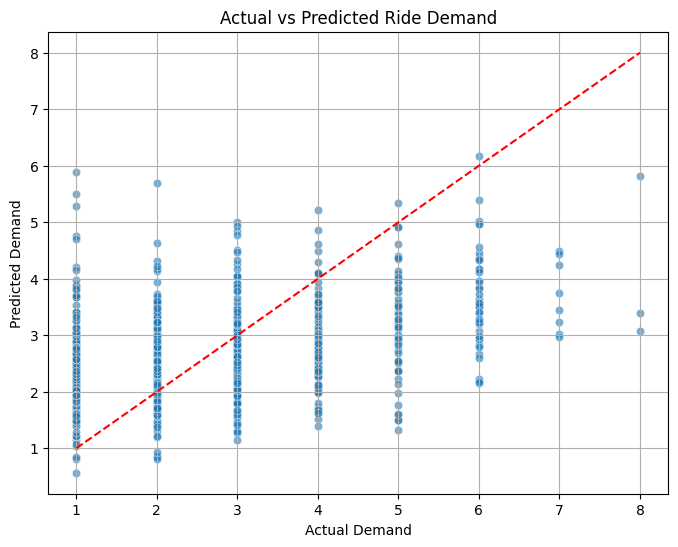

In [ ]:
# Predicted vs Actual Plot (on Test Set)

# This shows how close the predictions are to actual values. Ideally, the points should fall close to the diagonal line.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual Demand")
plt.ylabel("Predicted Demand")
plt.title("Actual vs Predicted Ride Demand")
plt.grid(True)
plt.show()

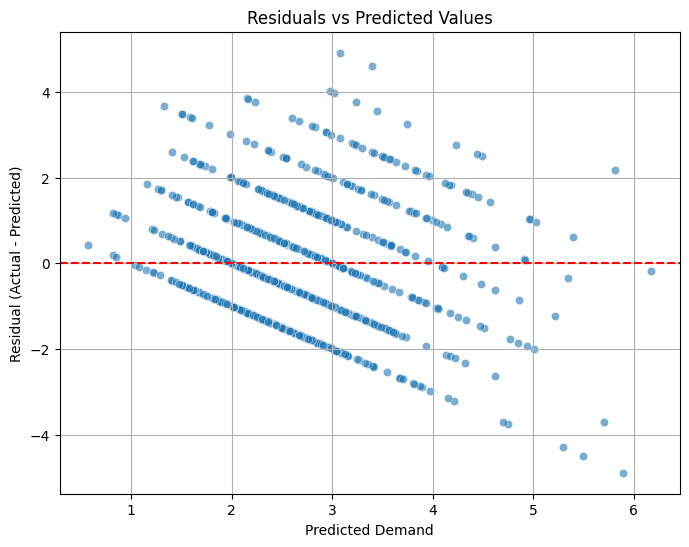

In [ ]:
# Residual Plot (Errors vs Predictions)
# It shows Whether your model has bias or patterns in errors (Residuals)
# Ideally, residuals should be randomly scattered around zero (no pattern).

residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Demand")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted Values")
plt.grid(True)
plt.show()

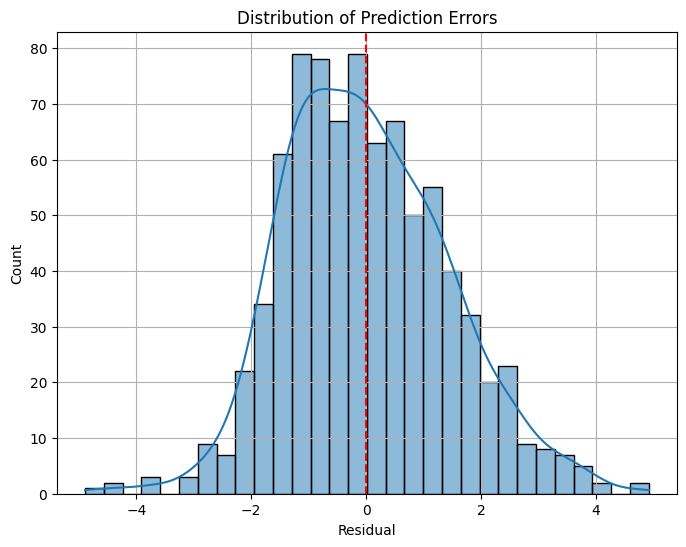

In [ ]:
# Distribution of Residuals (How well errors are distributed)
# This helps check if the model’s errors are centered around zero (a good sign) or skewed
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residual")
plt.title("Distribution of Prediction Errors")
plt.axvline(0, color='red', linestyle='--')
plt.grid(True)
plt.show()

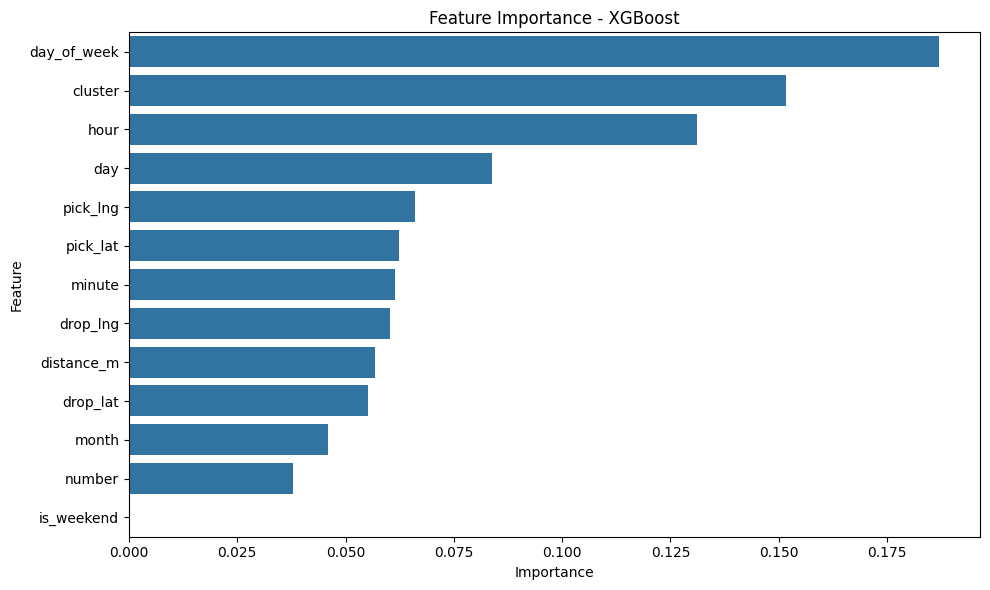

In [71]:
#  Feature Importance (from XGBoost)
importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()